## Running the gan with different parameters and architectures a evalute the outcomes on small scale simulations.

Run the simulations with
```
python main.py
```

Options are read from `defaults.py` and overridden by options in an `options.py` file, if present. So copy and rename `defaults.py` without modifying it and change options in `options.py`.

If an option is a list, e.g. `generator_depth = [4, 5, 6]`, the program will run multiple times with different parameters, logging the results. Attention: making to many parameters into a list may take long time because the program will run every combination in the cartesian product.

Process is logged in `last_run.log` and metrics about the runs are saved in `last_run.csv`.

In [2]:
import numpy as np
import seaborn as sb
import pandas as pd
from random import randint, choice
import torch
from importlib import reload
import os
import glob
from types import SimpleNamespace
import logging
import visualization

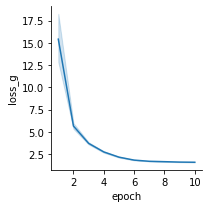

In [5]:
gm = pd.read_csv("last_run.csv")
g = sb.FacetGrid(gm, col="num_filtes")
g.map(sb.lineplot, "epoch", "loss_g")